<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>

![im](images/banner.png)


<font face="Calibri">

# Introduction and data preparation

<br>
<font size="3"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<b>This notebook covers the following concepts:</b>

- Test data explaination.
- Naming conventions and global settings.
- Setting up the folders.
</font>


</font>

In [1]:
# import what required

%matplotlib notebook

from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import geopandas as gpd
import rasterio as ras
from rasterio.plot import show

from sandpyper.common import create_transects

C:\anaconda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


___

## Introduction

**Sandpyper** is an open-source Python package that automates profile-based volumetric and altimetric analysis of sandy
beaches. It facilitates the cleaning of the elevation data from unwanted non-sand points or
swash areas (where waves run up on the beach slope and 3D reconstruction is inaccurate), integrates __Limit of Detection analysis (LoD)__, which are the expected vertical error when computing change from one survey to another) and allows to model beachface behavioural regimes using the __Beachface Cluster Dynamics (BCD)__ indices. It combines a file naming convention with some user-provided global settings and keep the analys coherent by containing it into two main classes:
* __ProfileSet__ class: manages the elevation and colour data extraction and LoD analysis
* __ProfileDynamics__ class: manages volumetric, altimetric and BCD analysis

The user only needs to set-up the directories with all the DSMs and/or orthophotos correctly named and provide a few __global settings__ at the beginning of the analysis, then the rest is fully automated.

I provided some __[test data](https://github.com/npucino/sandpyper/blob/master/test_data.rar)__ and prepared __notebooks__ to introduce the main functionalities of the package, including:
1. test data extraction and global settings explaination
2. profile data extraction
3. sand labelling and data cleaning
4. multiscale beach volumetric analysis
5. multiscale beach cluster dynamics indices (BCDs indices)
6. space module (teaser)

These notebooks focus is in the code implementation. If you want to read more about the methods and theory behind, please refer to the __Documentation__.

For a real world application, refer to the paper "[Citizen science for monitoring seasonal-scale beach erosion and behaviour with aerial drones](https://doi.org/10.1038/s41598-021-83477-6)", where we analysed 85 surveys in 10 locations in Victoria, Australia.

## Test data

The __test_data.rar__ archive includes all the __input data__ you need to get you started and understand how Sandpyper works. <br>

>__DOWNLOAD TEST DATA__: Navigate to the test_data.rar page in the Sandpyper master repository in GitHub (__[link](https://github.com/npucino/sandpyper/blob/master/test_data.rar)__) and download it locally. Unzip the archive file (you can use the free software [WinRAR](https://www.win-rar.com/start.html?&L=0)) and take note of the location of the extracted folder. 

These inputs are what Sandpyper needs to operate at full capacity and are normally created either as part of a typical pipeline with a [Structure from Motion](https://en.wikipedia.org/wiki/Structure_from_motion, 'Structure from Motion wikipedia page') (digital photogrammetry) software ([Pix4D](https://www.pix4d.com/), [Agisoft Metashape](https://www.agisoft.com/), [MicMac](https://micmac.ensg.eu/index.php/Accueil) (free), [VisualSfM](http://ccwu.me/vsfm/) (free)) or manually digitised within a Geographic Information System (GIS,[Qgis](https://qgis.org/en/site/, 'Qgis homepage') highly reccomended!).<br>

The input dataset provided include:


> __Digital Surface Models (DSM)__: images where each pixel represent surface elevation at the time of survey. This test input dataset include 6 DSMs of a small demo area in St.Leonards (leo) beach and 9 in Marengo (mar) beach, both covering their first year of monitoring. These are Geotiffs in two Coordinate Reference Systems (CRS) which have been resampled at 1m resolution (from an original 2.5cm) for demo speed.<br><br>
  __orthophotos__: orthorectified aerial RGB images at the time of survey. This test input dataset include all the orthophotos of each DSM. In fact, in a typical SfM pipeline, the DSM is created first, then used to orthorectify a mosaic of aerial images and create orthophotos. <br><br>
  __transects__: shore-normal vectorial lines digitised in a GIS (as Geopackages, .gpkg, in the input test dataset) or created using Sandpyper function `create_transects()`.<br><br>
  __lod_transects__: vectorial lines digitised in a GIS (as Geopackages, .gpkg, in the input test dataset) over invariant features of the landscape (roads, roofs, ramps, big rocks, etc.) used to derive Limit of Detection (LoDs) statistics.<br><br>
  __cleaning masks__: polygon masks digitised on a GIS used to fine-tune unsupervised clustering algorithm (label_corrections.gpkg), masking out swash and water (watermasks.gpkg) and shore areas (shoremasks.gpkg).<br><br>
  __shorelines__: vector shorelines digitised in a GIS (as Geopackages, .gpkg, in the input test dataset) used to demonstrate the creation of transects with Sandpyper.


Feel free to drag and drop these files in your favourite GIS to have a look and feel on how they look, or, see below.

Once you extracted the __test_data.rar__ somewhere in your computer, set its path here below:

In [28]:
test_data_folder = r"C:\my_packages\sandpyper\examples\test_data"

Here I plot a survey orthophoto in matplotlib interactive window. Zoom in to an area of interest to have a better image. For better visualisation purposes I will only show the orthophoto but remember that Sandpyper extract and work with both elevation (from DSMs) and colour data (from orthophotos) when provided.

Here below I also plot the __watermasks__, used to mask out the swash and water from the analysis, and the __shoremask__, used to clip the area of interest within a smaller and more meaningful zone.

<IPython.core.display.Javascript object>


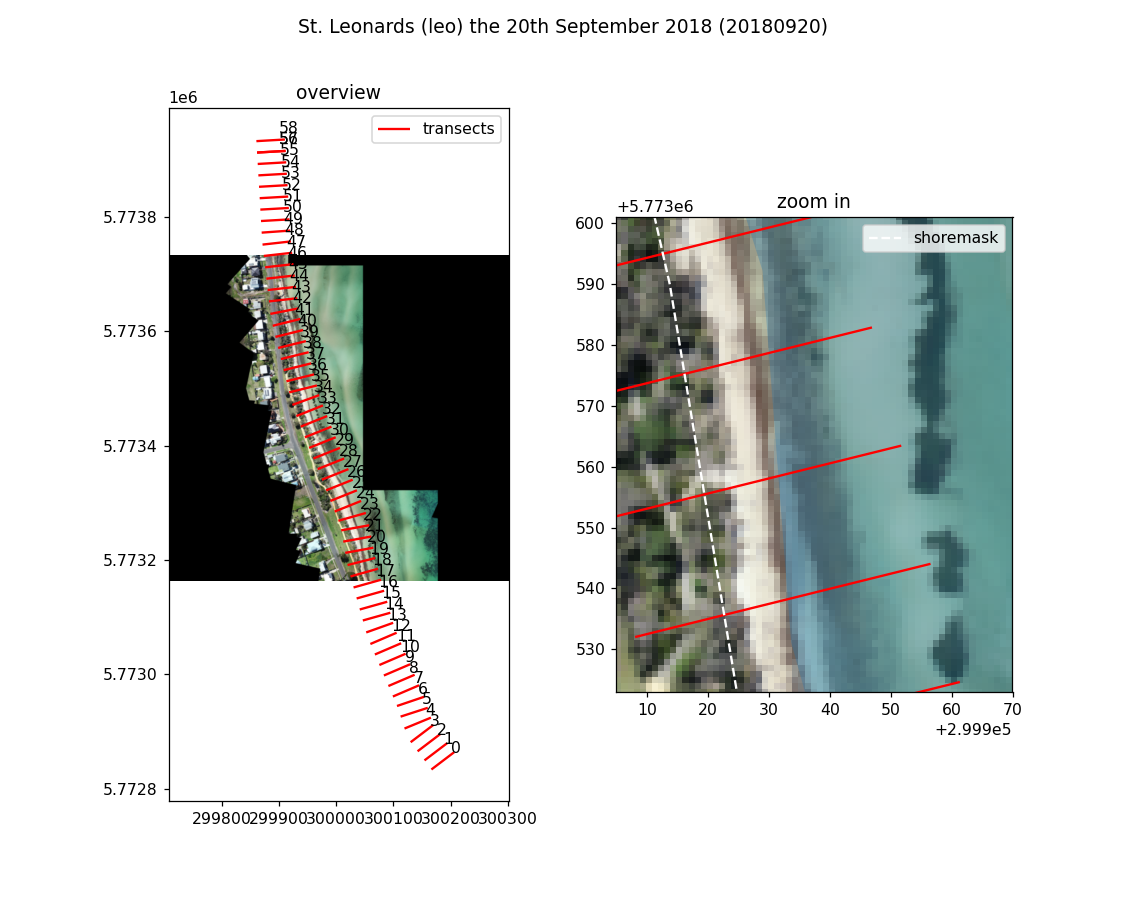

CRS of St.Leonards data:
   transects = epsg:32755
   ortho = EPSG:32755
   watermask = epsg:32754    
   shoremask= epsg:32754


In [30]:
%matplotlib notebook

f,axs= plt.subplots(1,2, figsize=(10,8), squeeze=True)

ortho_path=Path(test_data_folder + r"\orthos_1m\leo_20180920_ortho_resampled_1m.tif")
watermasks_path=Path(test_data_folder + r"\clean\watermasks.gpkg")
shoremasks_path=Path(test_data_folder + r"\clean\shoremasks.gpkg")
label_corr_path=Path(test_data_folder + r"\clean\label_corrections.gpkg")
transect_path=Path(test_data_folder + r"\transects\leo_transects.gpkg")
transect_lod_path=Path(test_data_folder + r"\lod_transects\leo_lod_transects.gpkg")

transects=gpd.read_file(transect_path)
watermasks=gpd.read_file(watermasks_path)
shoremasks=gpd.read_file(shoremasks_path)
label_corr=gpd.read_file(label_corr_path)
transect_lod=gpd.read_file(transect_lod_path)



with ras.open(ortho_path,'r') as ortho:
    # plot orthos
    show(ortho, ax=axs[0])
    show(ortho, ax=axs[1])
    
    # plot transects
    transects.plot(ax=axs[0], color='r', label='transects')
    transects.plot(ax=axs[1], color='r')
    
    # plot shoremask
    shoremask_leo_demo=shoremasks.query("location=='leo'") 
    shoremask_leo_demo.to_crs(32755).boundary.plot(ax=axs[1],color='w',linestyle='--',label='shoremask')
    
    # plot watermask
    watermask_leo_demo=watermasks.query("location=='leo' and raw_date==20180920")
    watermask_leo_demo.to_crs(32755).plot(ax=axs[1],alpha=.3,label='watermask')

    # add tr_id labels
    for x, y, label in zip(transects.geometry.centroid.x, transects.geometry.centroid.y, transects.tr_id):
            axs[0].annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points")

    # print coodinate reference systems
    print(f"CRS of St.Leonards data:\n   transects = {transects.crs}\n   ortho = {ortho.crs}\n   watermask = {watermask_leo_demo.crs}\
    \n   shoremask= {shoremask_leo_demo.crs}")
    
    # set up image
    f.suptitle("St. Leonards (leo) the 20th September 2018 (20180920)")
    axs[0].set_title("overview")
    axs[1].set_title("zoom in")
    
    axs[1].set_xlim(299904.9, 299970)
    axs[1].set_ylim(5773523, 5773601)
    
    axs[0].legend()
    axs[1].legend()

__Note on NaN__:
Not all the transects are within the extent of this orthophoto. Sandpyper will automatically assign __numpy.NaN__ to points that are outside the raster extent (transects in the white areas of overview image) and points that are within the extent of the raster, but the raster itself has NoData, if any, pixels (black areas of zoom image).

__Note on Coordinate Reference Systems__:

The output Geodataframes are in one CRSs only. This is due to the fact that in Geopandas GeoDataFrames we can only store __one CRS per geodataframe__. Similarly, Geopackages also want one CRS per file. Therefore, when you create the cleaning polygons in a GIS over multiple locations having different CRSs, __you have to work with one CRS for all polygons. In this test dataset, we chose the CRS of [epsg: 32754](https://epsg.io/?q=32754)__, which is the correct one for Marengo, but it is not the one used for St. Leonards, which is [epsg: 32755](https://epsg.io/?q=32755). Sandpyper uses a __CRS dictionary (see below)__ to automatically reproject transects and correction polygons to the correct input raster images CRS ( which of course can be in their correct CRS) when an overlay operation is needed to either extract information from the imagery or to clean or classify points.<br>
Remember this when you are visualising your profiles in a GIS. If the profiles seem to be in the wrong location it is probably because:

> you are displaying the orthophoto or DSM in its (correct) native CRS, while the Sandpyper-derived profile dataset you are trying to visualise is in another CRS (the CRS used for the corrections).

## Global settings

Sandpyper needs a few global settings to be set at the beginning of the analysis in order to keep the it coherent, which are:

* cordinate reference systems for each location (dictionary)
* location codes (list)
* location search keywords for automatic filename formatting (dictionary)
* transects for beach dynamics and Limit of Detection analysis (vector spatial file, Geopackage)
* correction polygons (vector spatial file, Geopackage)

Let's review each one of them.

### Location codes

When your analysis involve a multi-site approach, it is convenient to assign each location a __small code__ to easy the analysis and retrieval.

Here are some examples:
* Saint Leonards : __leo__
* Marengo : __mar__

In [3]:
# The location codes used troughout the analysis
loc_codes=["mar","leo"]

### Coordinate Reference Systems dictionary


Working on a wide area, often requires dealing with multiple Coordinate Reference Systems (CRS). Therefore, it is important to assign __each location code with its appropriate CRS__ at the beginning, in order to always take it into account trhoughout the analysis.

We do this with another dictionary, called `crs_dict_string`, where as keys we store the location codes and as values we store another dictionary, in this form `{'init': 'epsg:32754'}` .
Modify the __EPSG code__ to change CRS. Here is an example of the resulting dictionary:

```python
crs_dict_string = {'wbl': {'init': 'epsg:32754'},
                   'apo': {'init': 'epsg:32754'},
                   'prd': {'init': 'epsg:32755'},
                   'dem': {'init': 'epsg:32755'} }
```



> __NOTE:__ to specify the CRS, use the dictionary format supported by Geopandas 0.6.3. Only projected CRS are supported.


In [4]:
# The Coordinate Reference Systems used troughout this study

crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

### Naming conventions and spatial data fields

Here below are the naming conventions used in Sandpyper.

* __DSM image__: LocationCode_yyyymmdd_dsm.tif    (leo_20180606_dsm.tif)
* __orthophoto image__: LocationCode_yyyymmdd_ortho.tif    (mar_20180727_ortho.tif)
* __transect file__: LocationCode_transects.gpkg    (mar_transects.gpkg)
* __lod transect file__: LocationCode_lod_transects.gpkg    (leo_lod_transects.gpkg)
* __shoreline file__: LocationCode_shoreline.gpkg    (mar_shoreline.gpkg)





### Correction files

As the user needs to create polygons to use to clean the data (watermasks, shoremasks and label correcion masks), here below are some images showing how those polygon attributes need to be provided.

#### Shoremasks file

![im](images/shoremasks_table_attributes.jpg)

Shoremask file (geopackages or shapefiles) holds digitised polygons, which are clipping masks essentialy, which are used to remove unwanted backshore areas. In the above picture, the __red dashed line__ represents the boundary of the polygon, in this case, in Marengo (mar). It is one single clipping mask that will be applied to all surveys. The only required field is:

* location (string): location code

Every polygon has its own row and represent the shoremask of each location.  
Working with only one geopackage or shapefile implies that only one CRS has to be used for all the locations. This is automatically taken into account in Sandpyper using the __crs_dict_string__ global setting. 

#### Watermasks file

![im](images/watermasks_table_attributes.jpg)

Watermasks files (geopackages or shapefiles) are digitised over water areas and swash areas. It is one single file. The required fields are:

* location (string): location code
* raw_date (integer): survey date to apply this mask in raw for (yyyymmdd)

Every polygon has its own row and represent the watermask for each survey in each location.

#### Label correction file

![im](images/label_corr_attributes.jpg)

##### Obtain clean sediment dynamics

To obtain sand only subaerial beachface sediment dynamics, we need to eliminate all points across transects that capture non-sand or unreliable surfaces, such as vegetation, water (and swash) and anything else that is not sand.

How would you identify all sand points in a multi-millions points dataset?
Machine Learning (ML) can greatly help, ideally supervised classification algorithms could do the job for us by classifying and discriminating the different point classes extracted. However, it needs a lot of training data to be trained with, and as profile-based analysis deals with data points organised along cross-share transects rather than images (see Sandpyper roadmap!), digitising polygons on a GIS over points representing sand or other classes to create a large training dataset is feasible but time-consuming withouth an help.

__Sandpyper help comes here!__

Sandpyper currently implements a Machine Learning (ML) __unsupervised clustering algorithm (KMeans)__ to help label every point as one of the classes of interest, such as sand, water (and swash), vegetation and no sand. 
Kmeans will assign a label to points that share similarities in feature space, in each survey. Once you will plot the survey dataset in a GIS and overlay it on its correct orthophoto and represent the points with color-coded points based on the label KMeans assigned (column `label_k`), you will actually see what KMeans think are similar points.

>NOTE: what the algorithm see is almost always not what our brain is trained to see ! Unless you use perfect features, in that case let me know.

At this stage, you have grouped points in several KMeans labels (clusters) and it is your job to take note which labels are what type of surface class, such as vegetation, water, sand or no sand (anything else).
Although this approach is still quite time-consuming relative to using supervised classification algorithms (once you have a lot of training data), this method allow the user to classify the totality of the points in all surveys in a very accurate way, which give the user two possibilities:
1. use the classified points as they are, but all surveys must be classified (implemented in Sandpyper)
2. classify with Sandpyper several key survey (capture variance!), creating a big training dataset to train a custom supervised classification algorithm (not implemented at this stage)

##### Clean and rectify KMeans clusters

However, of course, KMeans is not perfect and sometimes yu will find labels that are clearly mostly vegetation, falling into water, for example.
In this case, you might want to rectify and correct the labels that KMeans returned, and this is facilitated by the __label correction files__.

##### Label correction files
Label correction files (geopackages or shapefiles) are digitised over points which have cluster labels (assigned by KMeans algorithm) which we are not totally happy with. The attribute `target_label_k` specifies which label k will be affected by the correction, leaving untouched all other points falling within the polygon but having different label k. This is useful to fine-tune the point classification, as it is covered in the notebook [2 - Profiles extraction, unsupervised sand labelling and cleaning.ipynb](https://github.com/npucino/sandpyper/blob/master/examples/2%20-%20Profiles%20extraction%2C%20unsupervised%20sand%20labelling%20and%20cleaning.ipynb). If you want to apply the correction to all the points, regardless of the label k, just assign `999` to this field.
The field `new_class` specifies the class to be assigned by the polygon. It is one single file. The required fields are:

* location (string): location code
* raw_date (integer): survey date to apply this mask in raw format (yyyymmdd)
* target_label_k (integer): label k to apply the correction of this polygon. 999 to apply to all points within it, regardless of their label k
* new_class (string): class to assign to the points of specified label k within the polygon

Every polygon has its own row and represent the correction polygons for each survey in each location.

> NOTE: If label correction polygons targeting the same label_k overlap and in their overlap area they include points with their target_label_k, the new class __MUST BE THE SAME__, otherwise it doesn't make sense as nobody knows that point in that shared area what new class should take!

### Location search dictionary

Sometimes, Sandpyper needs to automatically obtain the right location code and date from raster files, either of DSMs or orthophotos, whose filenames contains unformatted versions of the location name and date (e.g. Saint_Leonards_20180923 or Marengo_21_july_2019).

An easy and fast way to do this, is to create a dictionary, where __keys are the location codes__ and the __values are lists of possible full names__ we expect to find in the files.
Here are some examples:

```python
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }
```
> __NOTE__: always include the location codes in the list of possible names, in case the original raster filenames are already formatted!

In [34]:
# The terms used in the original filenames.
# These will be used to properly format files, extracting location codes.

loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }

## Input data and folder structure

All you need to do to work with Sandpyper is to put all your DSM files (geotiff, .tiff or .tif) into one folder and all the orthophotos files (geotiff, .tiff or .tif) into another folder.

Make sure the filenames of your imagery files follow the Sandpyper convention:

1. __DSM image__: LocationCode_yyyymmdd_dsm.tif (leo_20180606_dsm.tif)
2. __orthophoto image__: LocationCode_yyyymmdd_ortho.tif (mar_20180727_ortho.tif)

Similarly, put all transects geopackages (.gpkg) into one folder, all the Limit of Detection (LoD) transects into another folder and the shorelines (used to create transects) into another folder.

Make sure these files also follow Sandpyper naming convention:

1. __transect file__: LocationCode_transects.gpkg (mar_transects.gpkg)
2. __lod transect file__: LocationCode_lod_transects.gpkg (leo_lod_transects.gpkg)
3. __shoreline file__: LocationCode_shoreline.gpkg (mar_shoreline.gpkg)

For an example, check the [test_data](https://github.com/npucino/sandpyper/tree/master/examples/test_data) folder structure in the example directory.

### Transects

Any Shapely line or polyline object can be used as input as a transect. In coastal geomeorphometric studies, transects are usually equally spaced alongshore, and place normal to the shoreline. However, any type of line can be used to extract values from both orthophtos and DSMs.

You can construct transects in 2 ways:

1. Any GIS
2. Using the function __create_transects__, starting from a shoreline baseline.

If you use your favourite GIS (Qgis preferred), ensure that the output format is geopackage (.gpkg), each transect has its own separate row (geometry) and a transect ID column holds each transect, well, ID.

If you want to use in-built sandpyper function, see below:

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<IPython.core.display.Javascript object>


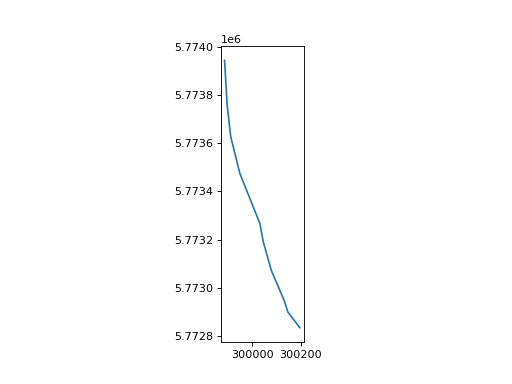

In [12]:
# load and display the shoreline
shoreline_path=r"C:\my_packages\sandpyper\examples\test_data\shorelines\leo_shoreline_short.gpkg"

shoreline=gpd.read_file(shoreline_path)
shoreline.plot();

<IPython.core.display.Javascript object>


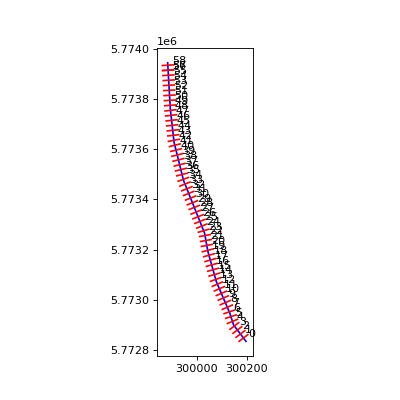

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,tr_id,geometry,location
0,0,"LINESTRING (300166.471 5772833.267, 300206.279...",leo
1,1,"LINESTRING (300154.369 5772849.190, 300194.177...",leo
2,2,"LINESTRING (300142.267 5772865.113, 300182.075...",leo
3,3,"LINESTRING (300130.166 5772881.037, 300169.974...",leo
4,4,"LINESTRING (300119.411 5772904.944, 300165.639...",leo


In [13]:
# create and display the transects (in red), give the shoreline (in blu)

f,ax=plt.subplots(figsize=(5,5))  # Change figsize if you want bigger images
location='leo'  # insert the location code for this transect file.

transects=create_transects(shoreline,
                           sampling_step=20, # alongshore transect spacing in meters
                           tick_length=50, # transects length in meters
                           location=location,
                           crs=crs_dict_string[location],
                           side='both' # 'both':transect is centered at the interesction with the baseline
                          )

# Modify the figure by plotting shoreline, transects and transect IDs.
shoreline.plot(ax=ax,color='b')
transects.plot(ax=ax,color='r')

for x, y, label in zip(transects.geometry.centroid.x, transects.geometry.centroid.y, transects.tr_id):
    ax.annotate(label, xy=(x, y), xytext=(4, 1), textcoords="offset points")

transects.head()

The following cell saves transect to file and name it as:

>__locationCode_whateverYouWant.gpkg__

(example: __leo_transects.gpkg__)

and place it to a folder where you store all the transects for each location.

>__Note:__ If the saving throws an error "PLE_NotSupported in dataset leo_transects.gpkg does not support layer creation option ENCODING", the file should be created and valid anyway. Double-check by opening it in Qgis.

In [8]:
#transects.to_file(filename=r'C:\save\here\your\leo_transects.gpkg',driver='GPKG')

## Conclusion

This lenghty notebook showed what Sandpyper needs to operate and what the input data should look like. In the next notebooks I will show how all this information will be analysed in a few lines of code using Sandpyper.